In [110]:
import pandas as pd
import numpy as np
import json
import time
import lightgbm as lgb
import matplotlib.pyplot as plt
import optuna

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from utils.system import *

#### Function

In [111]:
def get_metric(label, prediction):
    cm = confusion_matrix(label, prediction)
    TP = cm[1, 1]  # True Positives
    TN = cm[0, 0]  # True Negatives
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives
    
    # Calculate precision and recall for the positive class
    precision_pos = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall_pos = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_pos = 2 * (precision_pos * recall_pos) / (precision_pos + recall_pos) if (precision_pos + recall_pos) != 0 else 0
    
    # Calculate precision and recall for the negative class
    precision_neg = TN / (TN + FN) if (TN + FN) != 0 else 0
    recall_neg = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1_neg = 2 * (precision_neg * recall_neg) / (precision_neg + recall_neg) if (precision_neg + recall_neg) != 0 else 0
    
    # Display in a table
    metrics = pd.DataFrame({
        'Metric': ['Precision (Positive)', 'Recall (Positive)', 'F1 Score (Positive)',
                   'Precision (Negative)', 'Recall (Negative)', 'F1 Score (Negative)'],
        'Value': [precision_pos, recall_pos, f1_pos, precision_neg, recall_neg, f1_neg]
    })
    
    return metrics

#### Prep Data

In [230]:
# Read in data
article = pd.read_csv(get_data() / 'human_annotations_all_8000_overall.csv')
art_emb = pd.read_parquet(get_data() / 'bert_article_emb.parquet.brotli')
sentence_emb = pd.read_parquet(get_data() / 'bert_sentence_cosine.parquet.brotli')  
sent = pd.read_parquet(get_data() / 'bert_sentiment.parquet.brotli')
art_cos = pd.read_parquet(get_data() / 'bert_art_cosine.parquet.brotli')  
emotion = pd.read_parquet(get_data() / 'bert_emotion.parquet.brotli')
topic = pd.read_parquet(get_data() / 'lda_topic.parquet.brotli')
n_gram = pd.read_parquet(get_data() / 'n_gram.parquet.brotli')
lex_div = pd.read_parquet(get_data() / 'lexical_div.parquet.brotli')
readability = pd.read_parquet(get_data() / 'readability.parquet.brotli')
time = pd.read_parquet(get_data() / 'time.parquet.brotli')

In [231]:
# Merge all data together
merged_emb = (pd.merge(art_emb, sentence_emb, on='id', how='inner')
              .merge(sent, on='id', how='inner')
              .merge(art_cos, on='id', how='inner')
              .merge(emotion, on='id', how='inner')
              .merge(lex_div, on='id', how='inner')
              .merge(topic, on='id', how='inner')
              .merge(n_gram, on='id', how='inner')
              .merge(time, on='id', how='inner'))

In [232]:
# Stack article embeddings + sentence embeddings together into one array
merged_emb['comb_emb'] = merged_emb.apply(lambda row: [*row['bert_emb_art'], *row['bert_emb_min'], *row['bert_emb_max']], axis=1)

#### Word Count Feature

In [233]:
# Count
merged_emb['word_count'] = merged_emb['cleaned_article'].apply(lambda x: len(x.split()))

#### Undersample

In [234]:
# Undersample
undersample = merged_emb.sort_values('overall_label')
df_class_0 = undersample[undersample['overall_label'] == 0]
df_class_1 = undersample[undersample['overall_label'] == 1]
n_samples = min(len(df_class_0), len(df_class_1))
df_class_0_under = df_class_0.sample(n_samples)
df_class_1_under = df_class_1.sample(n_samples)
merged_undersample = pd.concat([df_class_0_under, df_class_1_under], axis=0)
merged_undersample = merged_undersample.sample(frac=1).reset_index(drop=True)

#### Tfidf vectorize

In [235]:
# Vectorize Text
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
tfidf_features = tfidf_vectorizer.fit_transform(merged_undersample['cleaned_article'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.drop('count', axis=1)

In [236]:
merged_undersample = pd.concat([merged_undersample, tfidf_df], axis=1)

#### Flatten word embeddings into columns

In [237]:
# Function to flatten an array-containing column
def flatten_column(dataframe, column_name):
    # Flatten the column
    flattened_features = np.stack(dataframe[column_name].values)
    # Create a new DataFrame from the flattened features
    flattened_df = pd.DataFrame(flattened_features, columns=[f'{column_name}_{i}' for i in range(flattened_features.shape[1])])
    return flattened_df

In [238]:
# Flatten each array-containing column
flattened_emb_all = flatten_column(merged_undersample, 'bert_emb_art')
flattened_emb_max = flatten_column(merged_undersample, 'bert_emb_max')
flattened_emb_min = flatten_column(merged_undersample, 'bert_emb_min')

# Concatenate the flattened DataFrames with the rest of the DataFrame
merged_undersample = pd.concat([flattened_emb_all, flattened_emb_max, flattened_emb_min, 
                                merged_undersample.drop(columns=['comb_emb', 'text', 'cleaned_article', 'bert_emb_art', 'bert_emb_max', 'bert_emb_min'])], axis=1)

#### Train/Val/Test Split

In [239]:
# Splitting the data into features and label
X = merged_undersample.drop('overall_label', axis=1)
y = merged_undersample['overall_label']

# First split into training (80%) and test (20%)
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Further split training (80%) into training (70%) and validation (30%)
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.3, random_state=42)

In [240]:
# Create the LightGBM dataset
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=['sent_score', 'emotion_num'], free_raw_data=False)
dval = lgb.Dataset(X_val, label=y_val, categorical_feature=['sent_score', 'emotion_num'], free_raw_data=False)

#### Optuna Hyperparameter Optimization

In [241]:
fixed_params = {
        "feature_pre_filter": False,
        'device_type': 'gpu', 
        'gpu_platform_id': 1, 
        'gpu_device_id': 0, 
        'gpu_use_dp': True,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': -1,
        'boosting': 'gbdt'
}

In [242]:
def objective(trial):
    # Tunable hyperparameters
    param_tuning = {
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "learning_rate": round(trial.suggest_float("learning_rate", 1e-5, 0.1), 3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "feature_fraction": round(trial.suggest_float("feature_fraction", 0.1, 1.0), 3),
        "min_gain_to_split": round(trial.suggest_float("min_gain_to_split", 0, 1.0), 3),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": round(trial.suggest_float("lambda_l1", 0, 5.0), 3),
        "lambda_l2": round(trial.suggest_float("lambda_l2", 0, 5.0), 3),
    }    

    # Combine fixed and tunable hyperparameters
    params = {**param_tuning, **fixed_params}

    # Train the model
    clf = lgb.train(params, dtrain, valid_sets=[dtrain, dval], num_boost_round=1000, callbacks=[lgb.early_stopping(25)])

    # Calculate and return the performance metric
    y_pred = clf.predict(X_test)
    trial.set_user_attr('predictions', y_pred)
    # metric = log_loss(y_test, y_pred)
    y_pred_binary = (y_pred >= 0.5).astype(int)
    f1 = get_metric(y_test, y_pred_binary)
    metric = f1.loc[f1['Metric'] == 'F1 Score (Positive)']['Value'].values[0]
    return metric

In [137]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

# Get the best parameters
best_params = study.best_params
print("-" * 60)
print("Best parameters:", best_params)

[I 2023-12-25 16:52:23,485] A new study created in memory with name: no-name-f08c8489-4904-4d9b-8e1e-695996a72835


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.230996	valid_1's binary_logloss: 0.453289


[I 2023-12-25 16:52:48,761] Trial 0 finished with value: 0.7819790828640386 and parameters: {'max_depth': 41, 'learning_rate': 0.029612088378634882, 'num_leaves': 73, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 136, 'lambda_l1': 0.0, 'lambda_l2': 5.7438634173352385}. Best is trial 0 with value: 0.7819790828640386.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.202992	valid_1's binary_logloss: 0.460515


[I 2023-12-25 16:52:58,851] Trial 1 finished with value: 0.7808 and parameters: {'max_depth': 5, 'learning_rate': 0.0877954062669241, 'num_leaves': 102, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 44, 'lambda_l1': 0.0, 'lambda_l2': 2.892851700802189}. Best is trial 0 with value: 0.7819790828640386.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.136127	valid_1's binary_logloss: 0.45383


[I 2023-12-25 16:53:17,607] Trial 2 finished with value: 0.7718446601941747 and parameters: {'max_depth': 15, 'learning_rate': 0.09129885533849838, 'num_leaves': 102, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 35, 'lambda_l1': 0.0, 'lambda_l2': 4.5336173265585265}. Best is trial 0 with value: 0.7819790828640386.


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.484356	valid_1's binary_logloss: 0.534778


[I 2023-12-25 16:54:49,739] Trial 3 finished with value: 0.7611336032388664 and parameters: {'max_depth': 44, 'learning_rate': 0.0011690685879117734, 'num_leaves': 245, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 88, 'lambda_l1': 0.0, 'lambda_l2': 7.79022556220868}. Best is trial 0 with value: 0.7819790828640386.


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.268365	valid_1's binary_logloss: 0.45704


[I 2023-12-25 16:56:41,757] Trial 4 finished with value: 0.7803700724054707 and parameters: {'max_depth': 32, 'learning_rate': 0.00456728414917694, 'num_leaves': 187, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 116, 'lambda_l1': 0.0, 'lambda_l2': 2.1237381752462428}. Best is trial 0 with value: 0.7819790828640386.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.153825	valid_1's binary_logloss: 0.454566


[I 2023-12-25 16:57:02,367] Trial 5 finished with value: 0.7873376623376623 and parameters: {'max_depth': 30, 'learning_rate': 0.06749825483469529, 'num_leaves': 128, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 47, 'lambda_l1': 0.0, 'lambda_l2': 6.1497089336340425}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.135649	valid_1's binary_logloss: 0.447264


[I 2023-12-25 16:57:26,227] Trial 6 finished with value: 0.7819063004846526 and parameters: {'max_depth': 10, 'learning_rate': 0.05568848416468359, 'num_leaves': 196, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 64, 'lambda_l1': 0.0, 'lambda_l2': 6.979145267530331}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.269943	valid_1's binary_logloss: 0.459598


[I 2023-12-25 16:57:34,935] Trial 7 finished with value: 0.7699757869249396 and parameters: {'max_depth': 40, 'learning_rate': 0.09480628892772011, 'num_leaves': 222, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 150, 'lambda_l1': 0.0, 'lambda_l2': 2.1160662840146314}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.190091	valid_1's binary_logloss: 0.449261


[I 2023-12-25 16:59:13,286] Trial 8 finished with value: 0.781275221953188 and parameters: {'max_depth': 23, 'learning_rate': 0.008597238341488657, 'num_leaves': 39, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 111, 'lambda_l1': 0.0, 'lambda_l2': 9.77897455996758}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.114706	valid_1's binary_logloss: 0.459017


[I 2023-12-25 16:59:43,364] Trial 9 finished with value: 0.7778668805132318 and parameters: {'max_depth': 41, 'learning_rate': 0.05194757536760215, 'num_leaves': 215, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 50, 'lambda_l1': 0.0, 'lambda_l2': 1.4784394110144872}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.237853	valid_1's binary_logloss: 0.462662


[I 2023-12-25 16:59:54,430] Trial 10 finished with value: 0.7772357723577235 and parameters: {'max_depth': 29, 'learning_rate': 0.07050872945668195, 'num_leaves': 283, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 200, 'lambda_l1': 0.0, 'lambda_l2': 4.349914489553118}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.16459	valid_1's binary_logloss: 0.455577


[I 2023-12-25 17:00:29,350] Trial 11 finished with value: 0.7813504823151126 and parameters: {'max_depth': 48, 'learning_rate': 0.028578539337425997, 'num_leaves': 121, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 153, 'lambda_l1': 0.0, 'lambda_l2': 6.541885448655764}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.193359	valid_1's binary_logloss: 0.457819


[I 2023-12-25 17:01:03,829] Trial 12 finished with value: 0.7795786061588331 and parameters: {'max_depth': 35, 'learning_rate': 0.025331913975231213, 'num_leaves': 31, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 150, 'lambda_l1': 0.0, 'lambda_l2': 5.72524548224165}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0940444	valid_1's binary_logloss: 0.450498


[I 2023-12-25 17:02:09,467] Trial 13 finished with value: 0.7741935483870968 and parameters: {'max_depth': 22, 'learning_rate': 0.03478845466534645, 'num_leaves': 144, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 20, 'lambda_l1': 0.0, 'lambda_l2': 8.840739138025064}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.159044	valid_1's binary_logloss: 0.458291


[I 2023-12-25 17:02:28,222] Trial 14 finished with value: 0.778046811945117 and parameters: {'max_depth': 36, 'learning_rate': 0.06955205859208562, 'num_leaves': 66, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 82, 'lambda_l1': 0.0, 'lambda_l2': 0.24153709698460357}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.190009	valid_1's binary_logloss: 0.453259


[I 2023-12-25 17:02:48,967] Trial 15 finished with value: 0.7765273311897107 and parameters: {'max_depth': 49, 'learning_rate': 0.04311125993763984, 'num_leaves': 72, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 131, 'lambda_l1': 0.0, 'lambda_l2': 5.3987066951666005}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.169607	valid_1's binary_logloss: 0.455198


[I 2023-12-25 17:03:03,950] Trial 16 finished with value: 0.7708502024291499 and parameters: {'max_depth': 27, 'learning_rate': 0.06874342931317348, 'num_leaves': 157, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 172, 'lambda_l1': 0.0, 'lambda_l2': 4.12485369175098}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.148441	valid_1's binary_logloss: 0.45235


[I 2023-12-25 17:04:03,754] Trial 17 finished with value: 0.776604386677498 and parameters: {'max_depth': 20, 'learning_rate': 0.018402456587434134, 'num_leaves': 72, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 78, 'lambda_l1': 0.0, 'lambda_l2': 7.968889702876362}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.178151	valid_1's binary_logloss: 0.450439


[I 2023-12-25 17:04:20,883] Trial 18 finished with value: 0.7728375101050929 and parameters: {'max_depth': 35, 'learning_rate': 0.061006346757682184, 'num_leaves': 133, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 99, 'lambda_l1': 0.0, 'lambda_l2': 6.456437082524875}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.19591	valid_1's binary_logloss: 0.451768


[I 2023-12-25 17:04:43,202] Trial 19 finished with value: 0.7776879547291835 and parameters: {'max_depth': 16, 'learning_rate': 0.040825063352597245, 'num_leaves': 102, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 127, 'lambda_l1': 0.0, 'lambda_l2': 3.4927737736926945}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.16823	valid_1's binary_logloss: 0.453428


[I 2023-12-25 17:04:56,501] Trial 20 finished with value: 0.7719869706840391 and parameters: {'max_depth': 43, 'learning_rate': 0.08065889998132703, 'num_leaves': 174, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 185, 'lambda_l1': 0.0, 'lambda_l2': 5.575282093288584}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.250226	valid_1's binary_logloss: 0.464225


[I 2023-12-25 17:05:07,323] Trial 21 finished with value: 0.7846277021617294 and parameters: {'max_depth': 4, 'learning_rate': 0.05558020734944892, 'num_leaves': 201, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 57, 'lambda_l1': 0.0, 'lambda_l2': 6.994173381966752}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.334017	valid_1's binary_logloss: 0.46923


[I 2023-12-25 17:05:16,504] Trial 22 finished with value: 0.7652315190901705 and parameters: {'max_depth': 2, 'learning_rate': 0.043983912126048616, 'num_leaves': 272, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 66, 'lambda_l1': 0.0, 'lambda_l2': 7.7266295798459925}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.11553	valid_1's binary_logloss: 0.45297


[I 2023-12-25 17:05:52,066] Trial 23 finished with value: 0.7781350482315114 and parameters: {'max_depth': 27, 'learning_rate': 0.06022016136038763, 'num_leaves': 164, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 22, 'lambda_l1': 0.0, 'lambda_l2': 7.079470780033425}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.115944	valid_1's binary_logloss: 0.457944


[I 2023-12-25 17:06:13,447] Trial 24 finished with value: 0.7846277021617294 and parameters: {'max_depth': 31, 'learning_rate': 0.08003004004308176, 'num_leaves': 120, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 60, 'lambda_l1': 0.0, 'lambda_l2': 8.792521108094368}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.12755	valid_1's binary_logloss: 0.452832


[I 2023-12-25 17:06:32,506] Trial 25 finished with value: 0.7829581993569132 and parameters: {'max_depth': 31, 'learning_rate': 0.08385769545256468, 'num_leaves': 125, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 59, 'lambda_l1': 0.0, 'lambda_l2': 9.986688558467115}. Best is trial 5 with value: 0.7873376623376623.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.104671	valid_1's binary_logloss: 0.454192


[I 2023-12-25 17:06:59,092] Trial 26 finished with value: 0.7907348242811502 and parameters: {'max_depth': 17, 'learning_rate': 0.07645598347795725, 'num_leaves': 251, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 39, 'lambda_l1': 0.0, 'lambda_l2': 8.477619769834288}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.115694	valid_1's binary_logloss: 0.45055


[I 2023-12-25 17:07:22,672] Trial 27 finished with value: 0.7884151246983104 and parameters: {'max_depth': 10, 'learning_rate': 0.07651162491422189, 'num_leaves': 253, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 36, 'lambda_l1': 0.0, 'lambda_l2': 8.813627428265798}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.140678	valid_1's binary_logloss: 0.452935


[I 2023-12-25 17:07:46,401] Trial 28 finished with value: 0.7849720223820945 and parameters: {'max_depth': 12, 'learning_rate': 0.07619653145999968, 'num_leaves': 299, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 36, 'lambda_l1': 0.0, 'lambda_l2': 9.255029633627139}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.14494	valid_1's binary_logloss: 0.455585


[I 2023-12-25 17:08:03,515] Trial 29 finished with value: 0.7797427652733119 and parameters: {'max_depth': 8, 'learning_rate': 0.09854778325587289, 'num_leaves': 244, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 35, 'lambda_l1': 0.0, 'lambda_l2': 8.234714122077085}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.173597	valid_1's binary_logloss: 0.458155


[I 2023-12-25 17:08:21,484] Trial 30 finished with value: 0.7711038961038962 and parameters: {'max_depth': 19, 'learning_rate': 0.06341282212238206, 'num_leaves': 258, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 94, 'lambda_l1': 0.0, 'lambda_l2': 8.507983390693438}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.109106	valid_1's binary_logloss: 0.449419


[I 2023-12-25 17:08:49,207] Trial 31 finished with value: 0.7830264211369095 and parameters: {'max_depth': 12, 'learning_rate': 0.07645026809550494, 'num_leaves': 300, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 35, 'lambda_l1': 0.0, 'lambda_l2': 9.374631191337789}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.1014	valid_1's binary_logloss: 0.450537


[I 2023-12-25 17:09:16,519] Trial 32 finished with value: 0.7813504823151126 and parameters: {'max_depth': 14, 'learning_rate': 0.07454443633592457, 'num_leaves': 298, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 39, 'lambda_l1': 0.0, 'lambda_l2': 9.244063469485369}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.116818	valid_1's binary_logloss: 0.456362


[I 2023-12-25 17:09:35,389] Trial 33 finished with value: 0.7804487179487181 and parameters: {'max_depth': 7, 'learning_rate': 0.08754588842191924, 'num_leaves': 274, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 48, 'lambda_l1': 0.0, 'lambda_l2': 9.066100758780804}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.130507	valid_1's binary_logloss: 0.454211


[I 2023-12-25 17:09:57,598] Trial 34 finished with value: 0.7813504823151126 and parameters: {'max_depth': 12, 'learning_rate': 0.08810292117866678, 'num_leaves': 236, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 29, 'lambda_l1': 0.0, 'lambda_l2': 7.392954185911283}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.14699	valid_1's binary_logloss: 0.457366


[I 2023-12-25 17:10:15,688] Trial 35 finished with value: 0.7802907915993539 and parameters: {'max_depth': 16, 'learning_rate': 0.07463825053381903, 'num_leaves': 257, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 75, 'lambda_l1': 0.0, 'lambda_l2': 6.370417992445228}. Best is trial 26 with value: 0.7907348242811502.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.109642	valid_1's binary_logloss: 0.452202


[I 2023-12-25 17:10:40,377] Trial 36 finished with value: 0.7909967845659163 and parameters: {'max_depth': 18, 'learning_rate': 0.06772259748766511, 'num_leaves': 228, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 50, 'lambda_l1': 0.0, 'lambda_l2': 8.21777542382094}. Best is trial 36 with value: 0.7909967845659163.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.144548	valid_1's binary_logloss: 0.458956


[I 2023-12-25 17:11:00,965] Trial 37 finished with value: 0.7851373182552505 and parameters: {'max_depth': 24, 'learning_rate': 0.06550994831893696, 'num_leaves': 223, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 71, 'lambda_l1': 0.0, 'lambda_l2': 5.050135415323965}. Best is trial 36 with value: 0.7909967845659163.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.147906	valid_1's binary_logloss: 0.450189


[I 2023-12-25 17:11:28,400] Trial 38 finished with value: 0.7862289831865493 and parameters: {'max_depth': 19, 'learning_rate': 0.04958192312254646, 'num_leaves': 207, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 48, 'lambda_l1': 0.0, 'lambda_l2': 8.306335663861981}. Best is trial 36 with value: 0.7909967845659163.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.110686	valid_1's binary_logloss: 0.455622


[I 2023-12-25 17:11:48,864] Trial 39 finished with value: 0.7784045124899276 and parameters: {'max_depth': 17, 'learning_rate': 0.09404705586007125, 'num_leaves': 186, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 52, 'lambda_l1': 0.0, 'lambda_l2': 7.550972785115801}. Best is trial 36 with value: 0.7909967845659163.


------------------------------------------------------------
Best parameters: {'max_depth': 18, 'learning_rate': 0.06772259748766511, 'num_leaves': 228, 'feature_fraction': 1.0, 'min_gain_to_split': 0.0, 'min_data_in_leaf': 50, 'lambda_l1': 0.0, 'lambda_l2': 8.21777542382094}


In [181]:
top_trial = sorted(study.trials, key=lambda t: t.value, reverse=True)[:1]
top_pred = [trial.user_attrs['predictions'] for trial in top_trial]
avg_pred = np.mean([pred for pred in top_pred], axis=0)
y_pred_binary = (avg_pred >= 0.50).astype(int)

#### Train Best Model

In [256]:
# Define parameters
final_params = {**best_params, **fixed_params}

# Train the model
lgb_early_stop = lgb.early_stopping(25)
clf = lgb.train(params, dtrain, valid_sets=[dtrain, dval], num_boost_round=1000, callbacks=[lgb_early_stop])

[LightGBM] [Info] Number of positive: 1708, number of negative: 1665
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 730248
[LightGBM] [Info] Number of data points in the train set: 3373, number of used features: 12361
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 2339 dense feature groups (7.53 MB) transferred to GPU in 0.018772 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506374 -> initscore=0.025498
[LightGBM] [Info] Start training from score 0.025498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain

In [244]:
y_pred = clf.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

In [245]:
metric = get_metric(y_test, y_pred_binary)
metric

,Metric,Value
0,Precision (Positive),0.776758
1,Recall (Positive),0.827362
2,F1 Score (Positive),0.801262
3,Precision (Negative),0.807623
4,Recall (Negative),0.752961
5,F1 Score (Negative),0.779335


#### Train Stack Model

In [249]:
y_train_pred = clf.predict(X_train)
y_train_pred_binary = (y_train_pred >= 0.5).astype(int)

y_val_pred = clf.predict(X_val)
y_val_pred_binary = (y_val_pred >= 0.5).astype(int)

In [250]:
# Create the LightGBM dataset
dtrain = lgb.Dataset(X_train, label=y_train_pred_binary, categorical_feature=['sent_score', 'emotion_num'], free_raw_data=False)
dval = lgb.Dataset(X_val, label=y_val_pred_binary, categorical_feature=['sent_score', 'emotion_num'], free_raw_data=False)

In [251]:
# Define parameters
final_params = {**best_params, **fixed_params}

# Train the model
lgb_early_stop = lgb.early_stopping(25)
clf = lgb.train(final_params, dtrain, valid_sets=[dtrain, dval], num_boost_round=1000, callbacks=[lgb_early_stop])

Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00396779	valid_1's binary_logloss: 0.148708


In [252]:
y_pred = clf.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

In [254]:
metric = get_metric(y_test, y_pred_binary)
metric

,Metric,Value
0,Precision (Positive),0.774046
1,Recall (Positive),0.825733
2,F1 Score (Positive),0.799054
3,Precision (Negative),0.805455
4,Recall (Negative),0.749577
5,F1 Score (Negative),0.776512


#### Plot Gain/Split

In [129]:
gain = clf.feature_importance(importance_type='gain')
split = clf.feature_importance(importance_type='split')
feature_names = clf.feature_name()
importance = pd.DataFrame({
    'Feature Name': feature_names,
    'Gain': gain,
    'Split': split
})
importance_gain = importance.sort_values(by='Gain', ascending=False)
importance_split = importance.sort_values(by='Split', ascending=False)

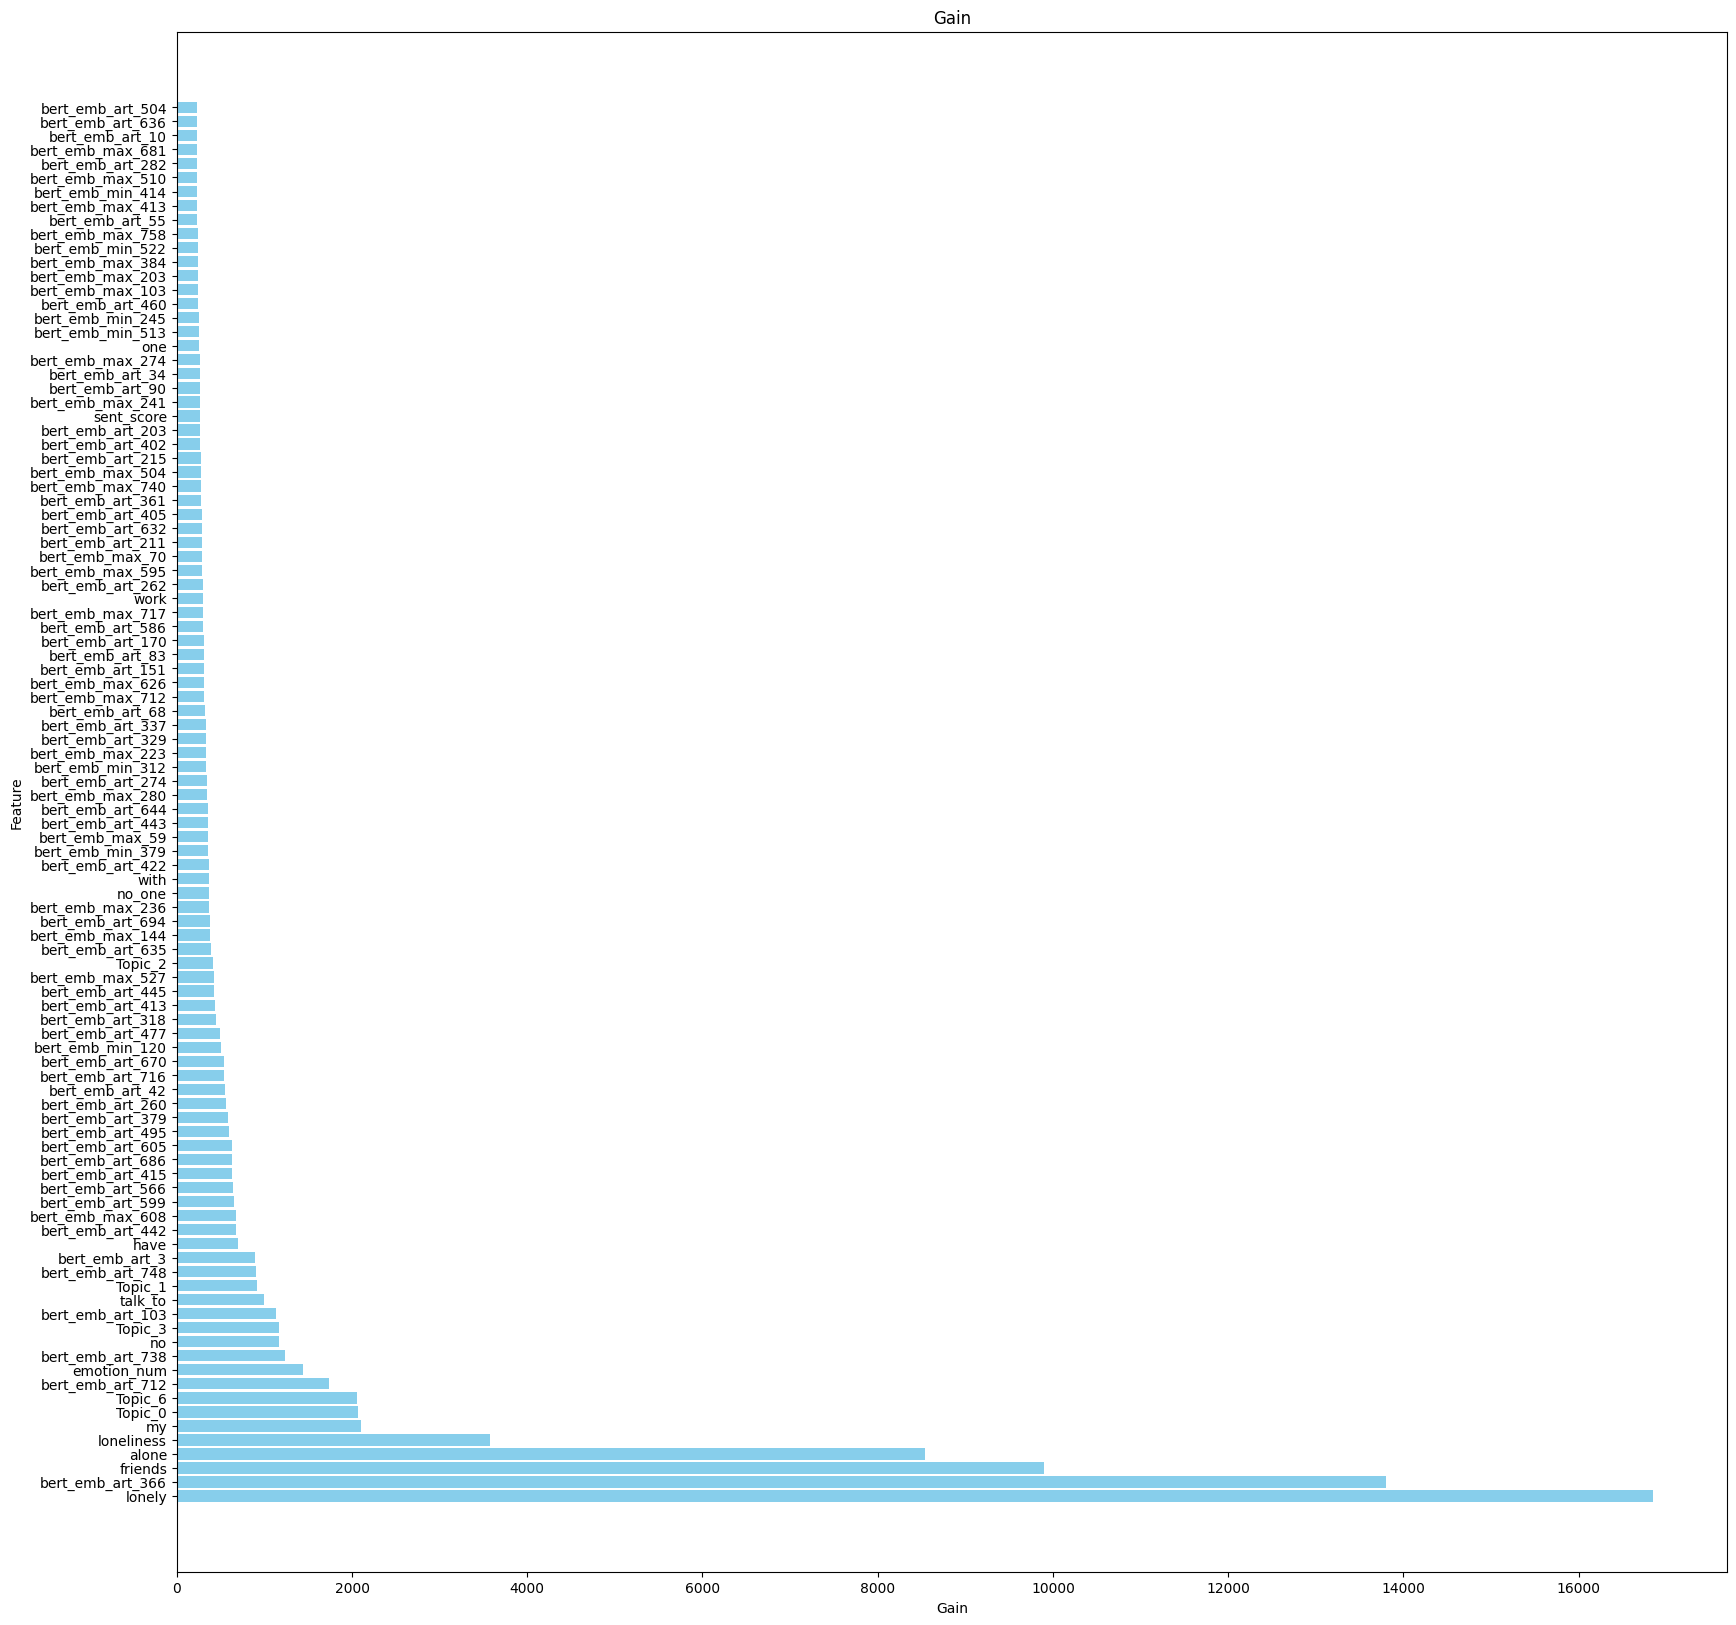

In [130]:
plt.figure(figsize=(20, 20))
plt.barh(importance_gain['Feature Name'].head(100), importance_gain['Gain'].head(100), color='skyblue')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.title('Gain')
plt.show()

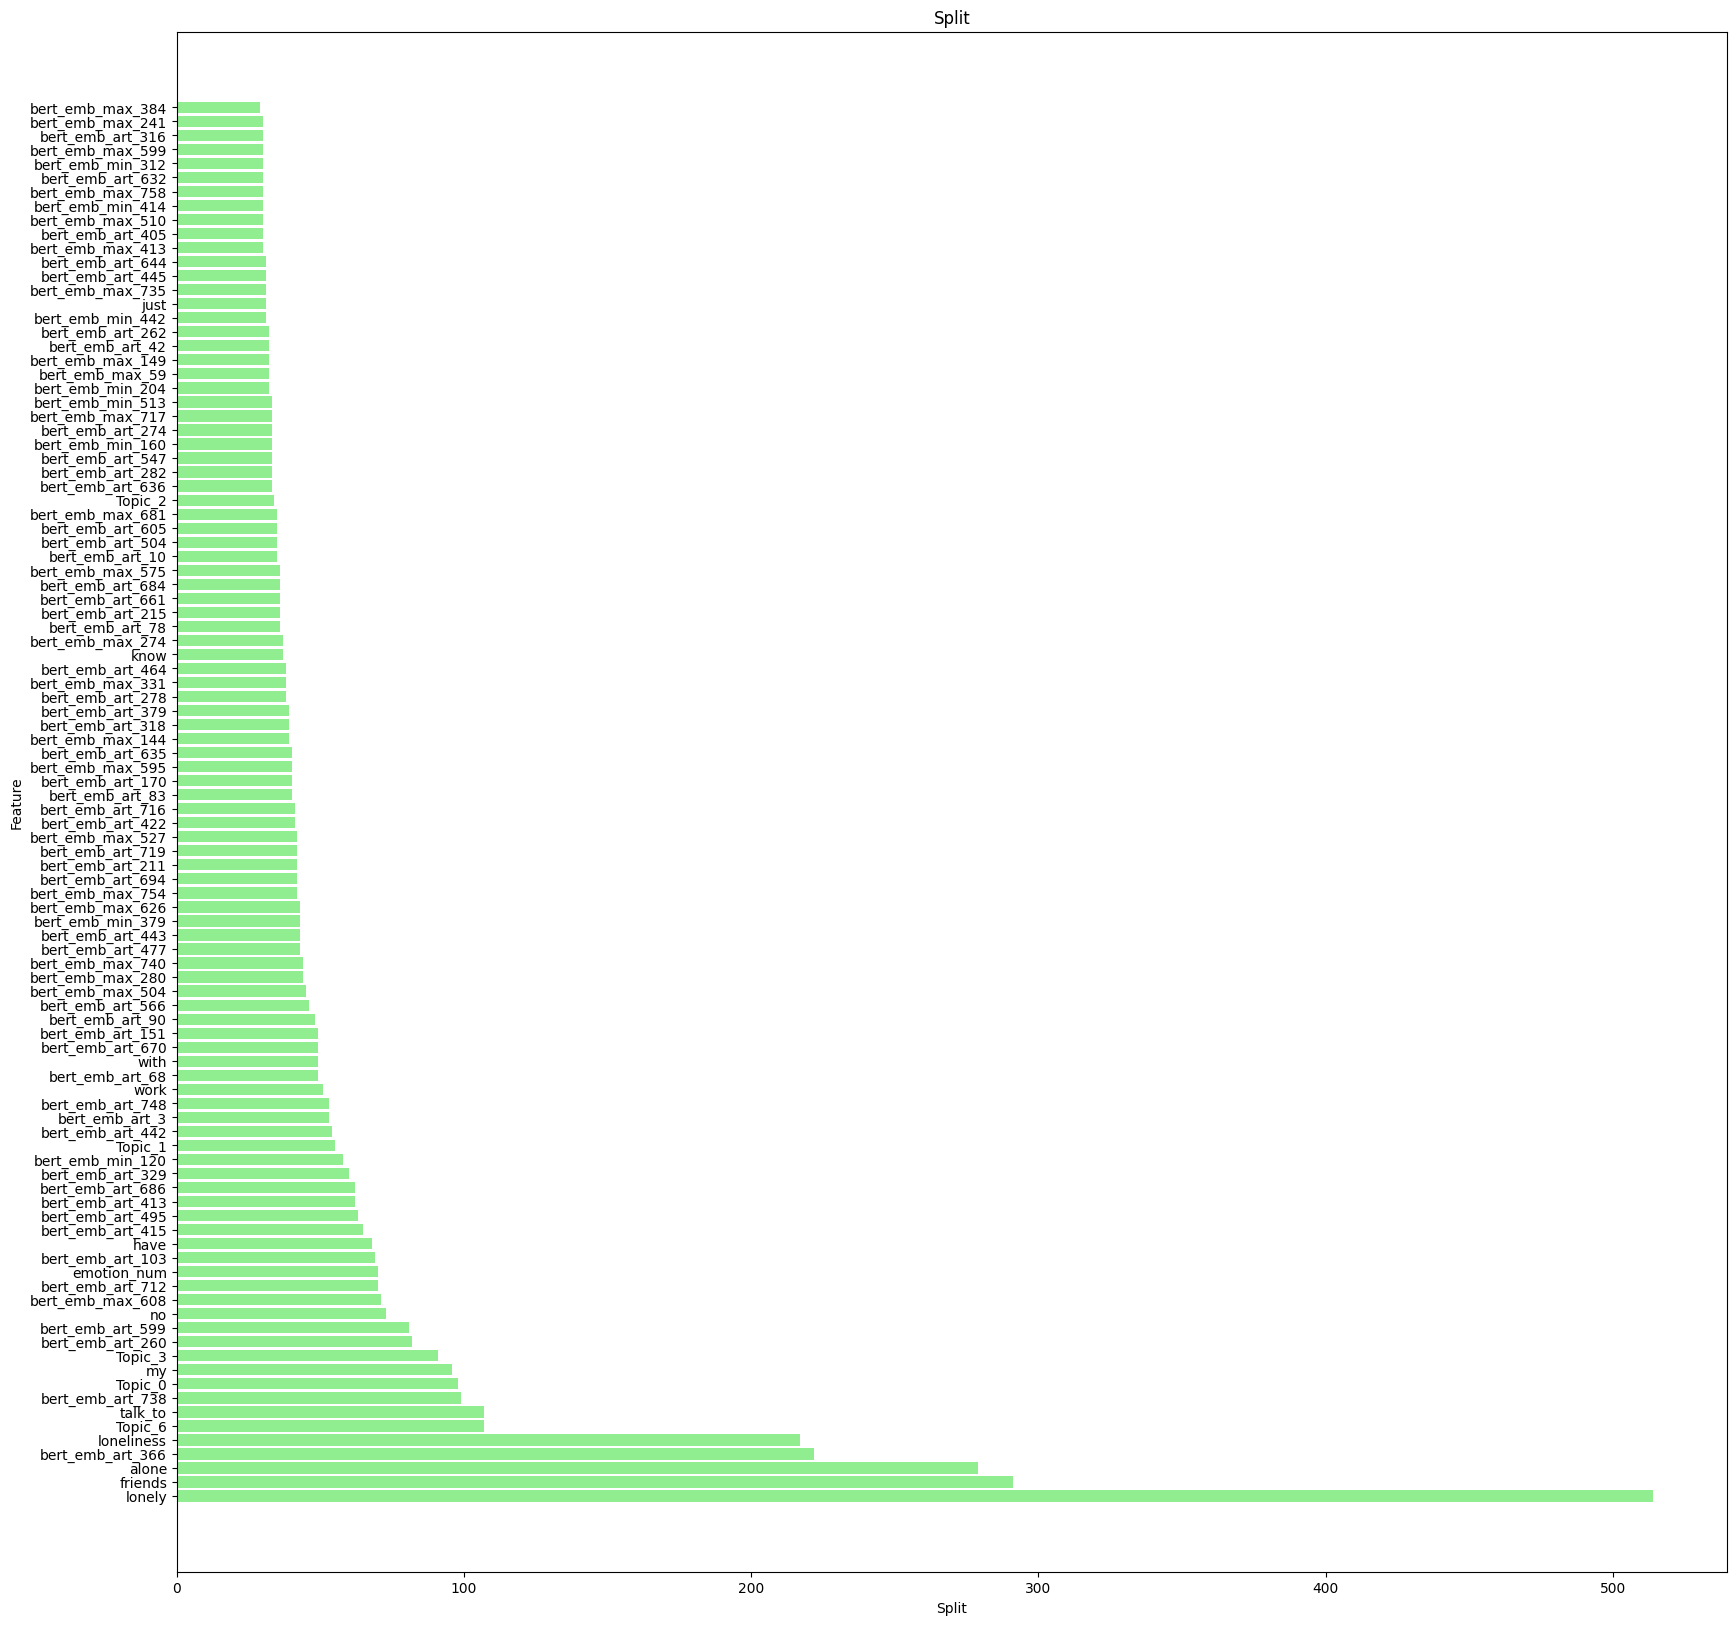

In [131]:
plt.figure(figsize=(20, 20))
plt.barh(importance_split['Feature Name'].head(100), importance_split['Split'].head(100), color='lightgreen')
plt.xlabel('Split')
plt.ylabel('Feature')
plt.title('Split')
plt.show()